## Прогнозирование температуры звезды

Задача от обсерватории: придумать, как с помощью нейросети определять температуру на поверхности обнаруженных звёзд. Обычно для расчёта температуры учёные пользуются следующими методами:    
*Закон смещения Вина.    
Закон Стефана-Больцмана.    
Спектральный анализ.*    
Каждый из них имеет плюсы и минусы. Обсерватория хочет внедрить технологии машинного обучения для предсказания температуры звёзд, надеясь, что этот метод будет наиболее точным и удобным.    
В базе обсерватории есть характеристики уже изученных 240 звёзд.    

**Характеристики** 

`Относительная светимость L/Lo` — светимость звезды относительно Солнца.    
`Относительный радиус R/Ro` — радиус звезды относительно радиуса Солнца.     
`Абсолютная звёздная величина Mv` — физическая величина, характеризующая блеск звезды.     
`Звёздный цвет (white, red, blue, yellow, yellow-orange и др.)` — цвет звезды, который определяют на основе спектрального анализа.    
`тип звезды` Коричневый карлик-0, Красный карлик-1, Белый карлик-2, Звёзды главной последовательности-3, Сверхгигант-4, Гипергигант-5    
`Абсолютная температура T(K)` — температура на поверхности звезды в Кельвинах.


## Загрузка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np 
import random

from math import ceil, sqrt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn

plt.style.use('seaborn-v0_8-darkgrid')
pd.options.mode.chained_assignment = None
torch.use_deterministic_algorithms(True)

In [2]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [3]:
df = pd.read_csv('file_name.csv', sep='\t' , index_col=0)

In [4]:
df.head()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,3068,0.002400,0.1700,16.12,0,Red
1,3042,0.000500,0.1542,16.60,0,Red
2,2600,0.000300,0.1020,18.70,0,Red
3,2800,0.000200,0.1600,16.65,0,Red
4,1939,0.000138,0.1030,20.06,0,Red


In [5]:
df.columns

Index(['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)',
       'Absolute magnitude(Mv)', 'Star type', 'Star color'],
      dtype='object')

In [6]:
num_cols = ['Luminosity(L/Lo)','Radius(R/Ro)','Absolute magnitude(Mv)'] #числовые признаки
cat_cols = ['Star type', 'Star color'] #категориальные признаки
target = ['Temperature (K)'] #целевой признак

Посмотрим на значения в категориальных столбцах

In [7]:
df['Star color'].unique() 

array(['Red', 'Blue White', 'White', 'Yellowish White', 'Blue white',
       'Pale yellow orange', 'Blue', 'Blue-white', 'Whitish',
       'yellow-white', 'Orange', 'White-Yellow', 'white', 'Blue ',
       'yellowish', 'Yellowish', 'Orange-Red', 'Blue white ',
       'Blue-White'], dtype=object)

Наблюдаем большое количество опечаток. В будущем нам надо будет это исправить

In [8]:
df['Star type'].unique()

array([0, 1, 2, 3, 4, 5], dtype=int64)

In [9]:
df.describe(include = 'all')

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
count,240.000000,240.000000,240.000000,240.000000,240.000000,240
unique,NaN,NaN,NaN,NaN,NaN,19
top,NaN,NaN,NaN,NaN,NaN,Red
freq,NaN,NaN,NaN,NaN,NaN,112
mean,10497.462500,107188.361635,237.157781,4.382396,2.500000,NaN
std,9552.425037,179432.244940,517.155763,10.532512,1.711394,NaN
min,1939.000000,0.000080,0.008400,-11.920000,0.000000,NaN
25%,3344.250000,0.000865,0.102750,-6.232500,1.000000,NaN
50%,5776.000000,0.070500,0.762500,8.313000,2.500000,NaN
75%,15055.500000,198050.000000,42.750000,13.697500,4.000000,NaN


**Вывод**
`Temperature (K)` простирается от 2_000 градусов (красные звёзды) до 40_000 градусов (голубые звезды)    
`Luminosity(L/Lo)` в относительной светимости std достигает 179432 при среднем значении 107188
Так же в данных характеристиках очень большой разброс значений 

В `Star Color` 19 значений уникальных значений. В будущей их обработаем. 

## Предобработка и анализ данных

Проверка на пропуски

In [10]:
df.isna().sum().to_frame()

,0
Temperature (K),0
Luminosity(L/Lo),0
Radius(R/Ro),0
Absolute magnitude(Mv),0
Star type,0
Star color,0


На дубликаты

In [11]:
df.duplicated().sum()

0

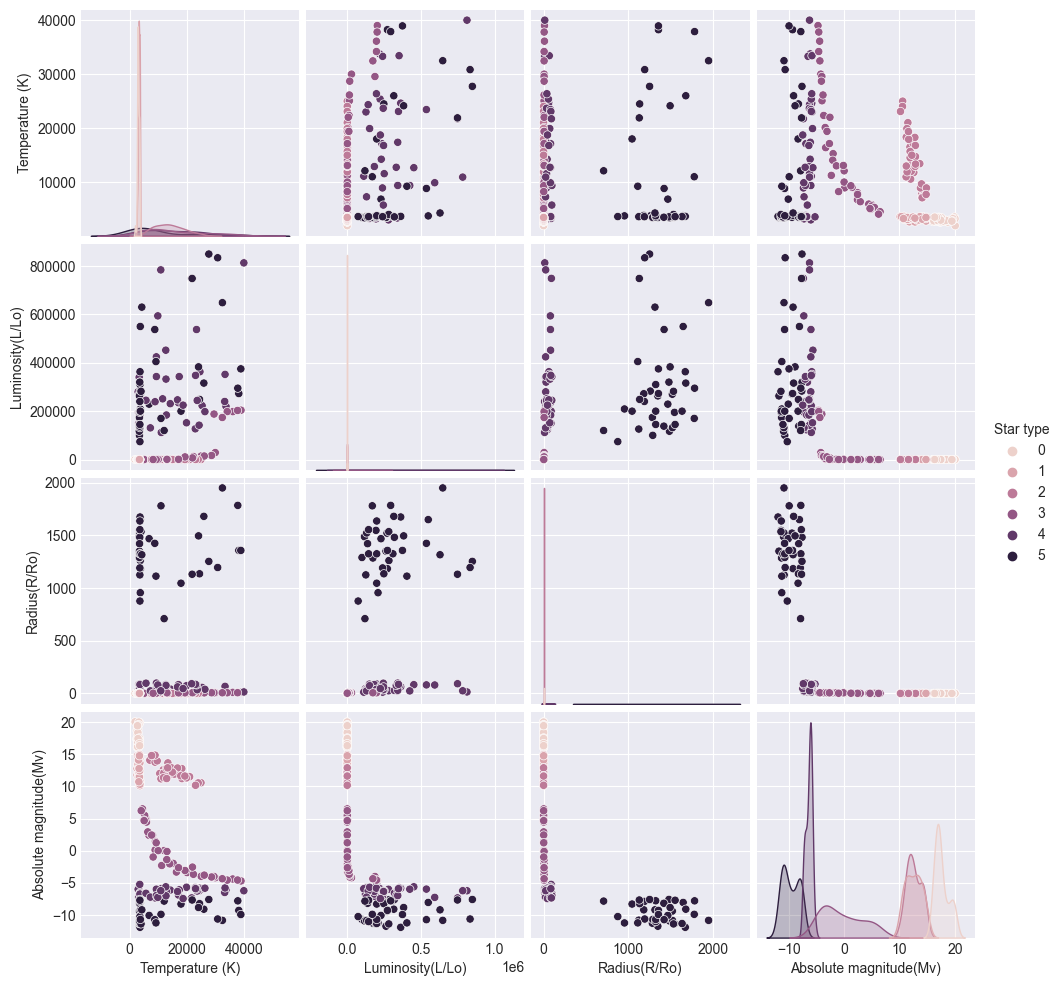

In [12]:
sns.pairplot(df, hue='Star type');

С увеличением температуры начинает уменьшаться абсолютная звёздная величина    
При помощи радиуса можно выделить тип звезды     
Хорошо выделяются кластеры типа звезды в зависимости абсолютной звёздой величины

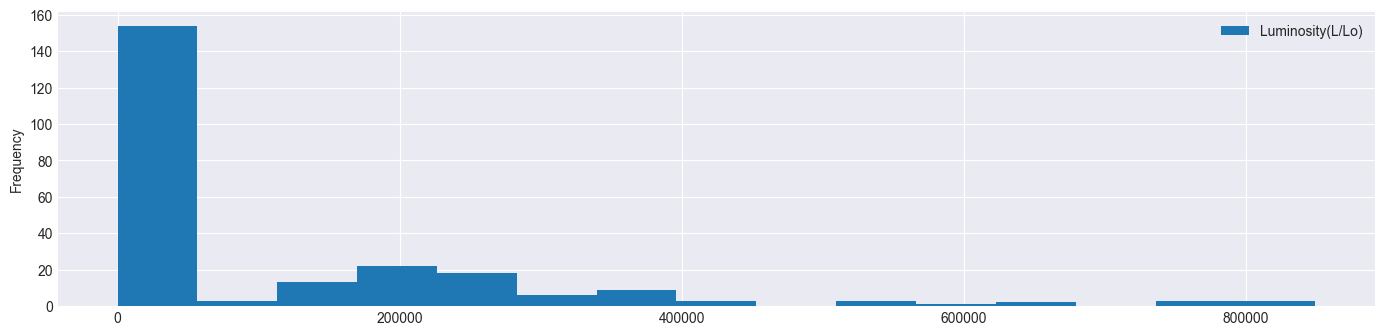

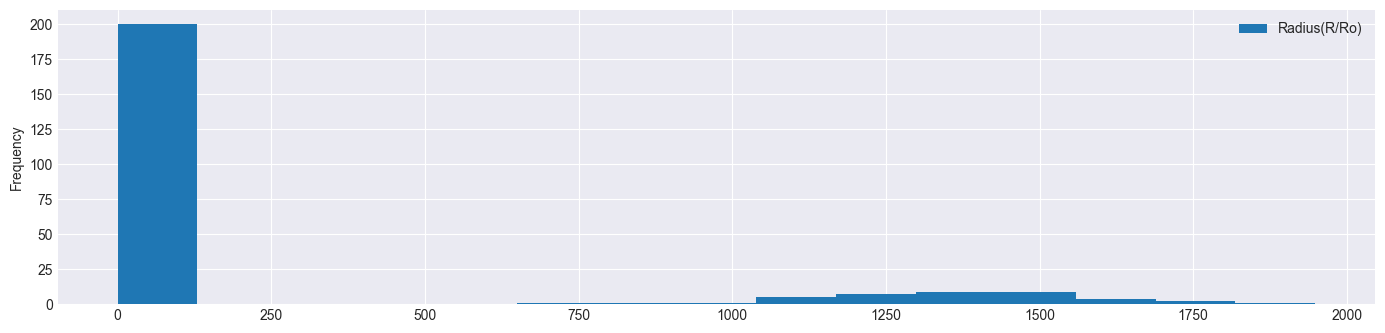

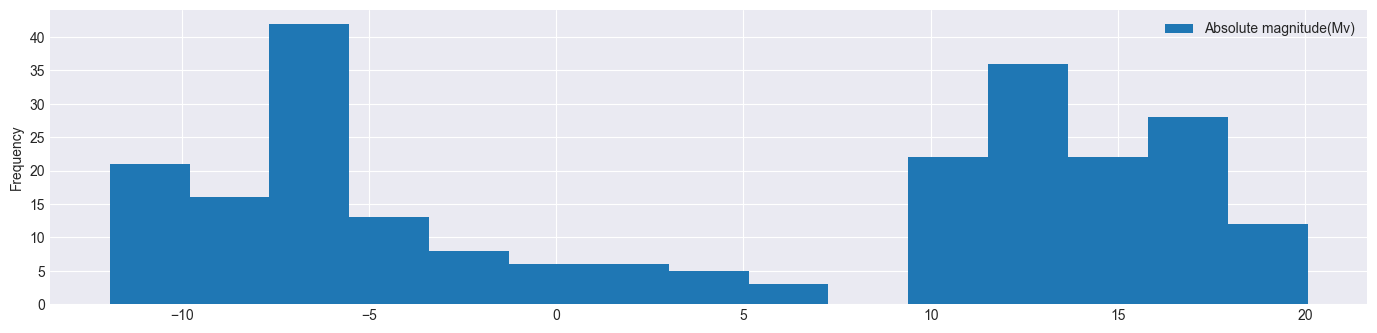

In [13]:
fig = plt.figure()
for i in range(len(num_cols)):
    plt.subplot(len(num_cols), 1, i+1)
    df[num_cols[i]].plot(kind = 'hist', bins = 15, grid = True, legend = num_cols[i], figsize = (17,13))
    plt.show()

В первых двух столбцах большинство значений находится в диапазоне от 0 до 150. 
Будь датасет больше или не будь задача связанная с астрономией, пришлось бы обрабатывать значения от выбросов

Посмотрим получше на категориальные переменные 
Напоминаю в начале надо исправить ошибки в цвете звёзд 

In [14]:
df['Star color'].value_counts()

Red                   112
Blue                   55
Blue-white             26
Blue White             10
yellow-white            8
White                   7
Blue white              3
Yellowish White         3
white                   3
Whitish                 2
Orange                  2
yellowish               2
Pale yellow orange      1
White-Yellow            1
Blue                    1
Yellowish               1
Orange-Red              1
Blue white              1
Blue-White              1
Name: Star color, dtype: int64

1) Можем увидеть, что есть опечатки в названиях. Например `Blue-white` и `Blue White`    
2) Некоторых классы существуют в единичном экземпляре.    
3) Так же открыв учебники по астронимии у нас в классификации цвета звёзд существуют неизвестные классы для науки.   

Делаю предположение, что в данных целевая характеристика определена правильно и при помощи маленькой функции я перезапишу цвет звезды в зависимости от температуры 

Так же хочу выделить, что есть классы звезд, которых не существует в стандартной спецификации 

In [15]:
def star_color(x):
    if x > 30000:
        return 'Blue'
    elif 30000 >= x > 10000:
        return 'Blue_white'
    elif 10000 >= x > 7400:
        return 'White'
    elif 7400 >= x > 6000:
        return 'Yellow_white'
    elif 6000 >= x > 5000:
        return 'Yellow'
    elif 5000 >= x > 3800:
        return 'Orange'
    else:
        return 'Red'

In [16]:
df['Star color'] = df['Temperature (K)'].apply(star_color)

In [17]:
df['Star color'].value_counts()

Red             109
Blue_white       76
White            21
Blue             14
Yellow_white      7
Orange            7
Yellow            6
Name: Star color, dtype: int64

In [18]:
df['Star type'] = df['Star type'].astype(dtype='object')

### Обработка при помощи ONE и StandartScaler

In [19]:
X = df.drop(target, axis = 1).copy()
y = df[target].copy()

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=3214)

In [21]:
for x,y,z in zip((y_train, y_test),(X_train, X_test), ('тренировочной', 'тестовой')):
    print(f'В {z} выборке, размеры матрицы признаков  = {y.shape}, целевого признака = {x.shape}')

В тренировочной выборке, размеры матрицы признаков  = (192, 5), целевого признака = (192, 1)
В тестовой выборке, размеры матрицы признаков  = (48, 5), целевого признака = (48, 1)


In [22]:
for i in [X_train, X_test, y_train, y_test]:
    i.reset_index(drop=True, inplace=True)

Обрабатываем категориальные признаки

In [23]:
OHE = OneHotEncoder(sparse=False, drop = 'first', handle_unknown = 'error')

X_train_cat = pd.DataFrame(OHE.fit_transform(X_train.loc[:,cat_cols]))
X_train_cat.columns = OHE.get_feature_names_out(cat_cols)
X_train.drop(cat_cols, axis = 1, inplace = True)
X_train = pd.concat([X_train, X_train_cat], axis = 1)

X_test_cat = pd.DataFrame(OHE.transform(X_test.loc[:,cat_cols]))
X_test_cat.columns = OHE.get_feature_names_out(cat_cols)
X_test.drop(cat_cols, axis = 1, inplace = True)
X_test = pd.concat([X_test, X_test_cat], axis = 1)


Переходим к масштабированию числовых признаков

In [24]:
scaler = StandardScaler()

X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [25]:
X_train.head()
#посмотрим как выглядит тренировочный набор данных после обработки 

,Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type_1,Star type_2,Star type_3,Star type_4,Star type_5,Star color_Blue_white,Star color_Orange,Star color_Red,Star color_White,Star color_Yellow,Star color_Yellow_white
0,-0.627498,-0.440475,-0.145987,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.496468,2.230756,-1.387146,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-0.627506,-0.442579,1.477650,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,-0.627506,-0.442030,0.756244,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,-0.627506,-0.442717,0.754351,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


## Построение базовой нейронной сети

В начале переведём наши данные к тензорам

In [26]:
X_train = torch.FloatTensor(X_train.values)
X_test  = torch.FloatTensor(X_test.values)
y_train  = torch.FloatTensor(y_train.values)
y_test = torch.FloatTensor(y_test.values)

Настраиваем количество нейронов на слоях сети 

In [27]:
n_in_neurons = 14
n_hidden_neurons_1 = 50
n_hidden_neurons_2 = 20
n_out_neurons = 1

In [28]:
class Model(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
        super(Model, self).__init__()
        
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        
        return x          

In [29]:
net = Model(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons) #модель 
loss=nn.MSELoss()

optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
optimizer1 = torch.optim.RMSprop(net.parameters(), lr=1e-3)
optimizer2 = torch.optim.Adam(net.parameters(), lr=1e-2)
optimizer3 = torch.optim.Adamax(net.parameters(), lr=1e-2)

In [30]:
def cross_vall_score(model, X_train, y_train, optim, num_epochs=250, batch_size=6, k=4, loss=nn.MSELoss()):
    '''Функция для кросс-валидации нейронной сети'''
    num_batches = ceil(len(X_train)/batch_size) # количество батчей 
    num_val_samples = len(X_train)//k # размер валидационной выборки 
    all_scores = []
    
    for i in range(k): 
        #разбиваем на валидационную и тренировочную выборку 
        print('processing fold #', i+1, end='  ')
        
        #обнуляем веса нейронной сети
        for layer in model.children():
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()
            
        #валидационная выборка
        val_data = X_train[i*num_val_samples: (i+1)*num_val_samples]
        val_targets = y_train[i*num_val_samples: (i+1)*num_val_samples]
        
        #тренировочная выборка
        partial_train_data = np.concatenate([X_train[:i*num_val_samples], X_train[(i+1)*num_val_samples:]], axis = 0)
        partial_train_targets = np.concatenate([y_train[:i*num_val_samples], y_train[(i+1)*num_val_samples:]], axis = 0)
        
        #приводим наши данные к формату FloatTensor
        val_data = torch.FloatTensor(val_data)
        val_targets = torch.FloatTensor(val_targets)
        partial_train_data = torch.FloatTensor(partial_train_data)
        partial_train_targets = torch.FloatTensor(partial_train_targets)
        
        for epoch in range(num_epochs):
            #создаем случайную перестановку индексов для каждой эпохи
            order = np.random.permutation(len(partial_train_data))
            for batch_idx in range(num_batches):
                start_index = batch_idx * batch_size #стартовый индекс батча
                optim.zero_grad() #обнуляем градиаенты
                
                #извлекаем батч
                batch_indexes = order[start_index:start_index+batch_size]
                X_batch = partial_train_data[batch_indexes]
                y_batch = partial_train_targets[batch_indexes]
                
                preds = net.forward(X_batch).flatten() #получаем предсказание
                loss_value = loss(preds, y_batch.flatten()) #высчитываем ошибку
                loss_value.backward()
                optim.step()
                
            if epoch == num_epochs-1:
                model.eval()
                val_preds = model.forward(val_data)
                RMSE_loss = torch.sqrt(loss(val_targets, val_preds))
                all_scores.append(RMSE_loss)
                print('RMSE метрика =', float(RMSE_loss))
    print('Средняя RMSE метрика =', int(sum(all_scores)/len(all_scores)),  '\n')
    return

In [31]:
x = [optimizer, optimizer1, optimizer2, optimizer3]

for i in x:
    print(i)
    cross_vall_score(net, X_train, y_train, i)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.001
    maximize: False
    weight_decay: 0
)
processing fold # 1  RMSE метрика = 6077.55224609375
processing fold # 2  RMSE метрика = 5214.10009765625
processing fold # 3  RMSE метрика = 5345.73974609375
processing fold # 4  RMSE метрика = 5070.201171875
Средняя RMSE метрика = 5426 

RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    differentiable: False
    eps: 1e-08
    foreach: None
    lr: 0.001
    maximize: False
    momentum: 0
    weight_decay: 0
)
processing fold # 1  RMSE метрика = 6231.0546875
processing fold # 2  RMSE метрика = 6566.34716796875
processing fold # 3  RMSE метрика = 5826.9384765625
processing fold # 4  RMSE метрика = 6129.68310546875
Средняя RMSE метрика = 6188 

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiab

Лучше всего себя показала оптимизация Adamax с шагом сходимости в 0.01

In [32]:
def neiron(model, X_train, y_train, optim, num_epochs = 250, batch_size = 6):
    '''Функция обучает нейронную сеть батчами с заданным количеством эпох'''
    num_batches = ceil(len(X_train)/batch_size)
    for epoch in range(num_epochs):
        order = np.random.permutation(len(X_train))
        for batch_idx in range(num_batches):
            start_index = batch_idx * batch_size 
            optim.zero_grad() 
        
            batch_indexes = order[start_index:start_index+batch_size] #индексы объектов текущего обатча
            X_batch = X_train[batch_indexes]
            y_batch = y_train[batch_indexes]
        
            preds = model.forward(X_batch).flatten() 
            loss_value = loss(preds, y_batch.flatten())
            loss_value.backward()
            optim.step()
    return  model

In [33]:
net = neiron(net, X_train, y_train, optimizer3) #обучаем модель с заданными параметрами 

In [34]:
net.eval()
test_preds = net.forward(X_test)
print('RMSE нейронной сети на тестовой выборке = ', int(torch.sqrt(loss(y_test, test_preds))))

RMSE нейронной сети на тестовой выборке =  3528


*Мы получили очень хорошие показатели. Попробуем их визуализировать и в будущем улучшить*

In [35]:
def vizualization(target, preds, width = 0.3):
    '''Визуализирует предсказания нейронной сети на тестовой выборке'''
    y1 = target.numpy().reshape([-1])
    y2 = preds.reshape([-1]).detach().numpy()
    x = np.arange(len(y1))
    
    fig,ax = plt.subplots()
    rects1 = ax.bar(x - width/2, y1, width, label = 'Факт')
    rects2 = ax.bar(x + width/2, y2, width, label = 'Прогноз')
    ax.set_title('Факт-Прогноз')
    ax.set_xticks(x)
    ax.set_xlabel('Номер звезды в таблице данных')
    ax.set_ylabel('Температура звезды')
    fig.set_figwidth(17)
    fig.set_figheight(10)
    ax.legend();

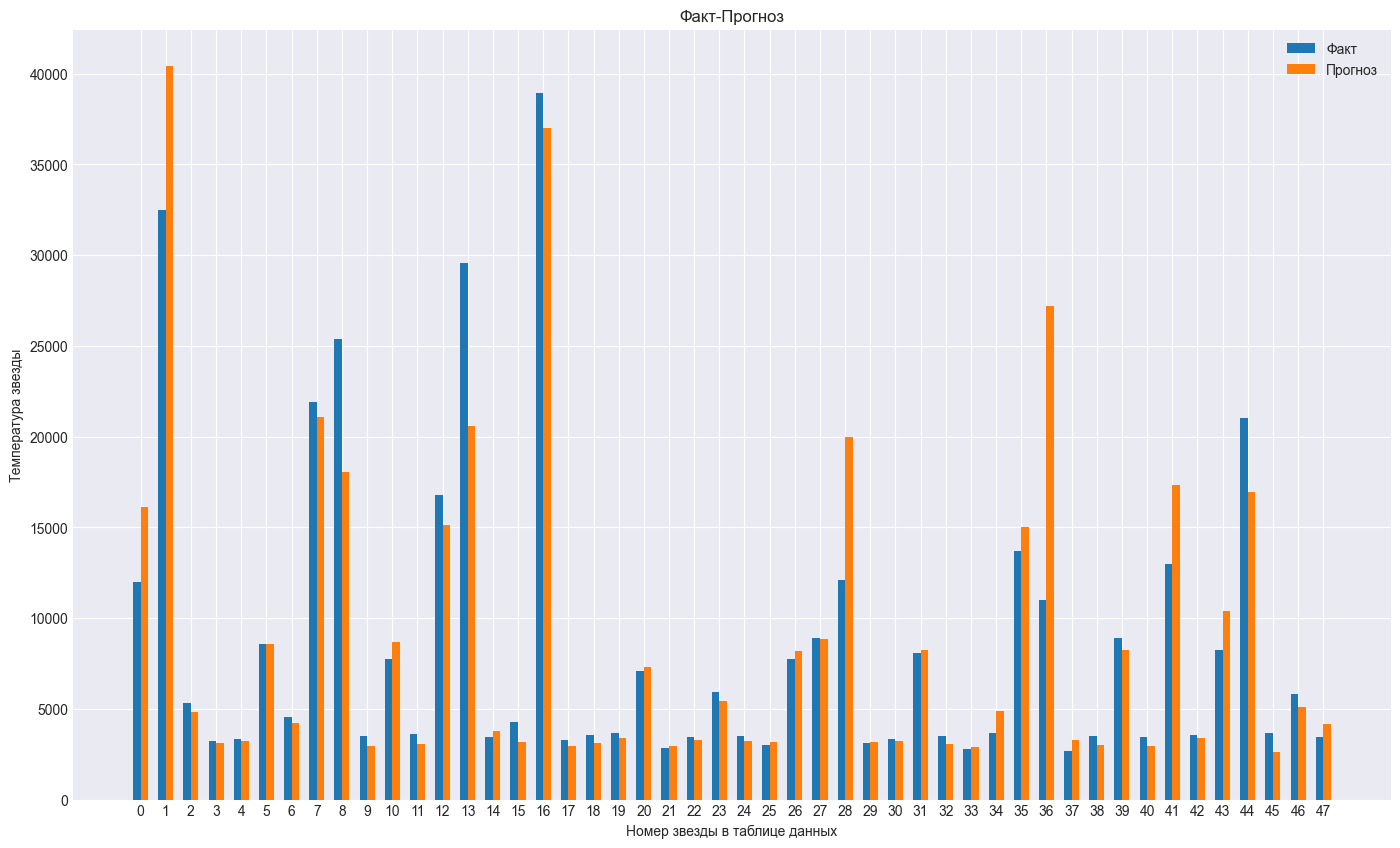

In [36]:
vizualization(y_test, test_preds)

**Вывод**   
Нейронная сеть очень хорошо предсказывает температуру звёзд у которых температура до 5000 градусов Очень плохо показал себя 36 экземпляр.

## Улучшение нейронной сети

Для улучшения нейронной сети попробуем применить Dropuot и BatchNorm1d. Далее проверим, позволят ли данные методы улучшить нашу нейронную сеть

In [37]:
class Model(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
        super(Model, self).__init__()
        
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.bn1 = nn.BatchNorm1d(n_hidden_neurons_1)
        self.act1 = nn.ReLU()
        self.dp2 = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.bn2 = nn.BatchNorm1d(n_hidden_neurons_2)
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.dp2(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.act2(x)
        x = self.fc3(x)
        
        return x  

In [38]:
net = Model(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)
loss = nn.MSELoss()


optimizer = torch.optim.RMSprop(net.parameters(), lr=1e-3)
optimizer1 = torch.optim.Adam(net.parameters(), lr=1e-3)
optimizer2 = torch.optim.Adam(net.parameters(), lr=1e-2)
optimizer3 = torch.optim.Adamax(net.parameters(), lr=1e-2)

In [39]:
x = [optimizer, optimizer1, optimizer2, optimizer3]

for i in x:
    print(i)
    cross_vall_score(net, X_train, y_train, i)

RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    differentiable: False
    eps: 1e-08
    foreach: None
    lr: 0.001
    maximize: False
    momentum: 0
    weight_decay: 0
)
processing fold # 1  RMSE метрика = 14379.7431640625
processing fold # 2  RMSE метрика = 5110.20751953125
processing fold # 3  RMSE метрика = 5173.8740234375
processing fold # 4  RMSE метрика = 4627.24365234375
Средняя RMSE метрика = 7322 

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.001
    maximize: False
    weight_decay: 0
)
processing fold # 1  RMSE метрика = 4903.90380859375
processing fold # 2  RMSE метрика = 3036.3857421875
processing fold # 3  RMSE метрика = 3340.237548828125
processing fold # 4  RMSE метрика = 3899.6953125
Средняя RMSE метрика = 3795 

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differenti

In [40]:
net = neiron(net, X_train, y_train, optimizer3)

In [41]:
net.eval()
test_preds = net.forward(X_test)
print('RMSE нейронной сети на тестовой выборке = ', int(torch.sqrt(loss(y_test, test_preds))))

RMSE нейронной сети на тестовой выборке =  3906


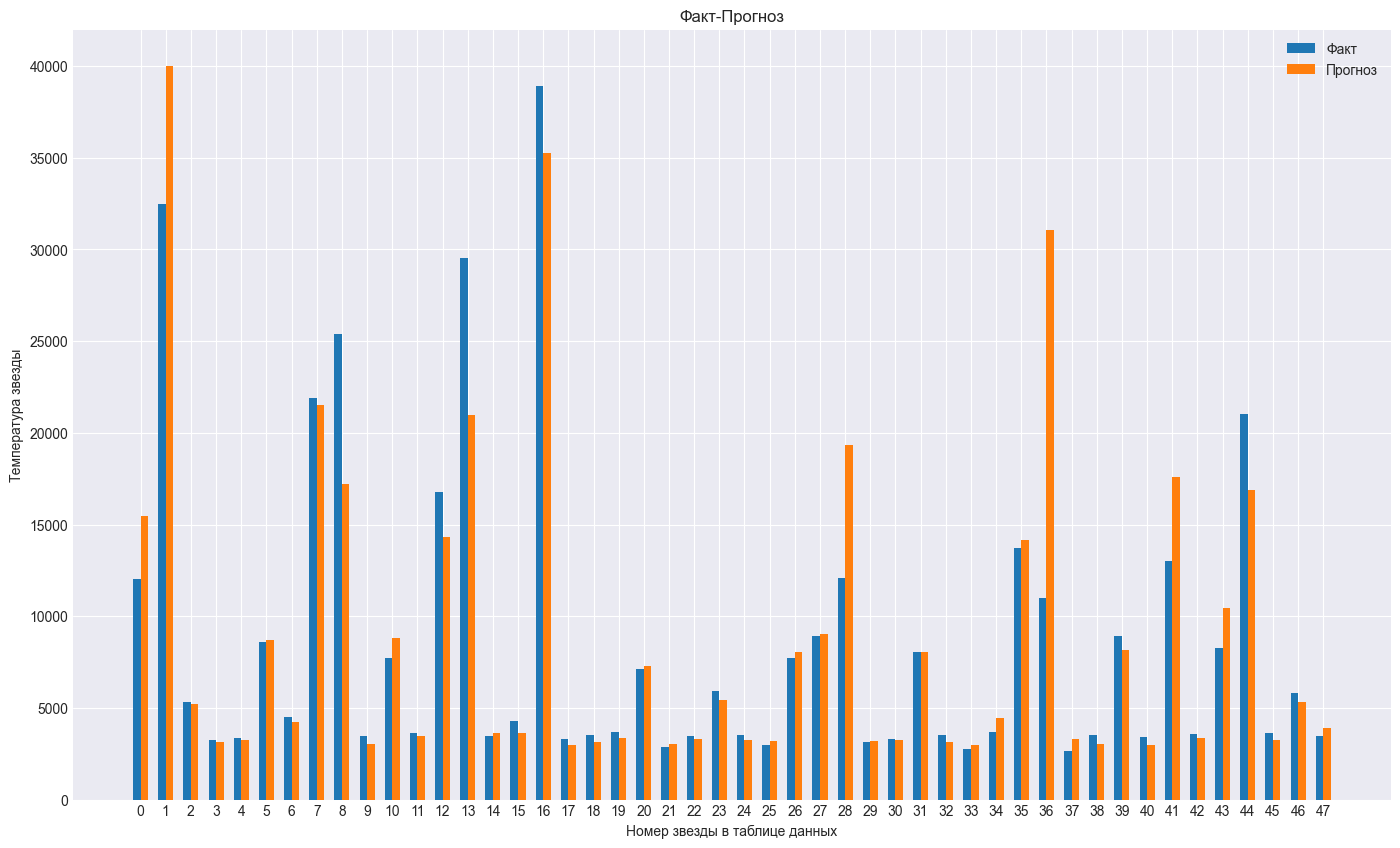

In [42]:
vizualization(y_test, test_preds)

## Вывод

Можно заметить, что после применения Dropuot и BatchNorm1d у нас RMSE увеличилось. Вместо 3528 мы с вами получили 3906 на тестовой выборке. Лучше всего использовать первую модель